# In which I brazenly defy Professor Ng and do his unsupervised algorithms homework in Python instead of Matlab.

Week 8 of Andrew Ng's ML course on Coursera discusses two very common unsupervised algorithms: K-Means Clustering for finding coherent subsets within unlabeled data, and Principle Component Analyis (PCA) for reducing the dimensionality of the data while retaining the largest amount of "information" possible. Here I use the homework data set to learn about the relevant python tools.

>## Tools Covered:
- `KMeans` for identifying a set number of coherent clusters in data
- `PCA` for dimensionality reduction on unlabeled data for speed or visualization purposes
- `LinearDiscriminantAnalysis` for dimensionality reduction on labeled data
- also `scipy.imread` and `ax.imshow` for working with matricized images

# Quick Look at the Data
Both of the algorithms we're practicing have their own toy data set in $R^2$ for us to play with at first. Afterwards we'll use the algorithms more realistically. With the clustering algorithm we'll attempt to "compress" a full color image by choosing the best reduced color set using K-Means. With PCA we'll try to compress the dimensionality of some large black and white images.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle

import snips as snp  # my snippets
snp.prettyplot(matplotlib)  # my aesthetic preferences for plotting
%matplotlib inline

In [2]:
cd hw-wk8

C:\Users\Sonya\Box Sync\Projects\course-machine-learning\hw-wk8


### Toy Data Sets

In [30]:
X1 = scipy.io.loadmat("ex7data2.mat")["X"]
X2 = scipy.io.loadmat("ex7data1.mat")["X"]

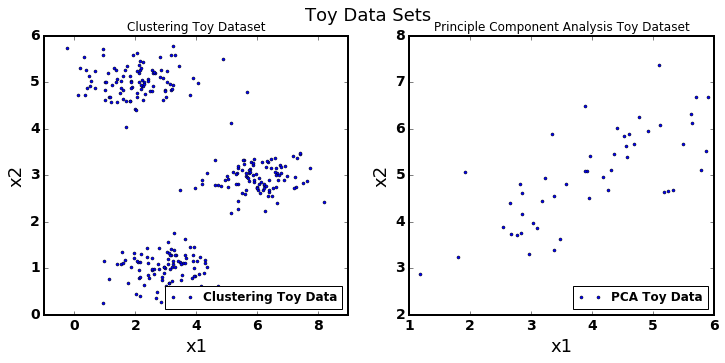

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Toy Data Sets", fontsize=18)

axs[0].plot(X1[:, 0], X1[:, 1], label="Clustering Toy Data", linestyle="None")
snp.labs("x1", "x2", "Clustering Toy Dataset", axs[0])
axs[0].legend(loc="lower right")

axs[1].plot(X2[:, 0], X2[:, 1], label="PCA Toy Data", linestyle="None")
snp.labs("x1", "x2", "Principle Component Analysis Toy Dataset", axs[1])
axs[1].legend(loc="lower right")

I don't anticipate either algorithm having much trouble :)

### Real Data 
The real data for both clustering and PCA are images. For clustering we just have one pretty picture of a parrot, while for PCA we have a matrix holding grey-scale pixel values for a bunch of face images. You can refer to [this excellent intro to using Scipy and Numpy for working with images](http://www.scipy-lectures.org/advanced/image_processing/). 

In [146]:
from scipy import misc
parrot = misc.imread("bird_small.png")

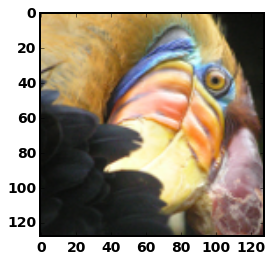

In [142]:
fig, ax = plt.subplots()
ax.imshow(parrot)

In [285]:
faces = scipy.io.loadmat("ex7faces.mat")["X"]

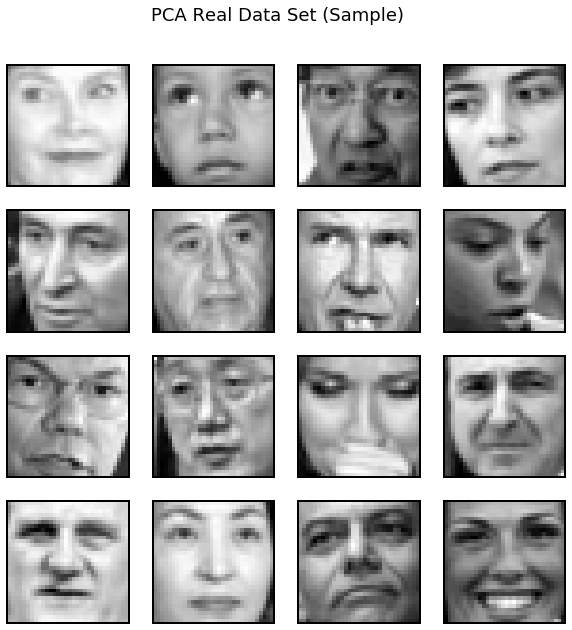

In [145]:
from numpy import random as rnd 
indxs = rnd.choice(np.arange(0, len(faces)), 16, replace=False)  # take a random sample of size 16 from set of index values

 # Create a new figure with 100 axes objects inside it (subplots)
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10)) 
fig.suptitle("PCA Real Data Set (Sample)", fontsize=18)
axs = axs.flatten()  # The returned axs is actually a matrix holding the handles to all the subplot axes objects
graymap = plt.get_cmap("gray")

for i, indx in enumerate(indxs):
    im_mat = np.reshape(faces[indx, :], (32, 32), order="F")
    axs[i].imshow(im_mat, cmap=graymap, interpolation="None")
    axs[i].xaxis.set_visible(False)  # Hide the axes labels for clarity
    axs[i].yaxis.set_visible(False) 

# K-Means Clustering Algorithm
This is a very simple algorithm, for a fixed $K$ it proceeds as follows:
- Randomly initialize $K$ points in feature space, called the *cluster centroids*
- Repeat until we approach steady-state:
    1. Assign each data point to the cluster whose centroid it is closest to.
    2. Recompute the location of each cluster centroid as the average position of points in that cluster.

**The above algorithm will tend to minimize the sum of squared distances between each point and its cluster's centroid - this is sometimes called the *Distortion Cost Function* and sometimes called *inertia*.** In the text above, step #1 of the algorithm minimizes inertia while keeping cluser centroid locations fixed and changing point assignments, while step #2 minimizes inertia while keeping the data points assignments to clusters fixed but changing centroid locations. **The K-Means outcome is sensitive to the initialization of centroids, so it's best to always run many times with different randomly initialized points.** 

This algorithm works well for roughly isotropic clusters, but not so well for weirdly shaped or elongated clusters. A great example image of this is on the official docs [here](http://scikit-learn.org/stable/_images/sphx_glr_plot_kmeans_assumptions_0011.png). An image so awesome that I *must* reproduce it below is also on the official docs [here](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png) - it shows the performance of different types of clustering algorithms on four very different data sets:

<img src=http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png width=900px></img>

## K-Means in Sklearn
The `sklearn` class for K-Means has all the knobs you could ever want to tune, the most important being obviously `n_clusters`. To dictate how many times the algorithm should be randomly seeded and run you can use `n_init`, then it will return only the best (in terms of lowest inertia) run of those. 

You `fit` the K-Means class with a dataset to choose optimal centroid locations, and then you can use it to `predict` the cluster assignment for new data points.

In [31]:
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=3, n_init=20)
clusters.fit(X1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

After "fitting" our clusterer we can access the centroid locations as well as a vector indicating assignment of each point to a cluster.

In [32]:
clusters.cluster_centers_

array([[ 3.04367119,  1.01541041],
       [ 1.95399466,  5.02557006],
       [ 6.03366736,  3.00052511]])

In [36]:
clusters.labels_[0:5]

array([1, 2, 2, 1, 1])

Let's visualize the movement of the centroid locations as the algorithm proceeds:

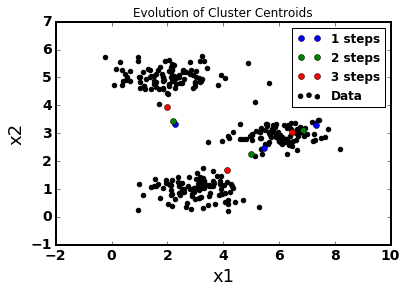

In [141]:
fig, ax = plt.subplots()
snp.labs("x1", "x2", "Evolution of Cluster Centroids")
ax.scatter(X1[:, 0], X1[:, 1], label="Data", c="k")

clusters.random_state = 11  # Make it start at the same place each time
clusters.n_init = 1  # Only let it run the algorithm one time

init_pts = np.array([[3, 3], [5, 2.5], [8, 5]])
clusters.init = init_pts # Initialize cluster centroids to specific location

for n in np.arange(1, 4):
    clusters.max_iter = n  # Max number of steps the algorithm is allowed to take
    clusters.fit(X1)
    cs = clusters.cluster_centers_
    ax.plot(cs[:, 0], cs[:, 1], linestyle="None", markersize=6, label="%i steps" %(n,))
ax.legend(loc="upper right")

## K-Means for Color Compression
In our original parrot photo each pixel has three bytes to represent the three intensity values of red, green and blue for that pixel. This is RGB encoding and it is capable of representing a *lot* of different colors. If there were only 16 possible colors in our image, we could represent the image with a much smaller piece of memory - we'd only need 4 bits per pixel to indicate which of the 16 colors it has. 

K-Means can help us transform a full RGB encoded image to a 16-color image by finding the centers of 16 clusters in the data set of all the pixel colors. Remember, a pixel color lives in $R^3$ because it has an intensity value (0 through 255) for each of red, green and blue. 

In [154]:
parrot.shape

(128, 128, 3)

<IPython.core.display.Javascript object>


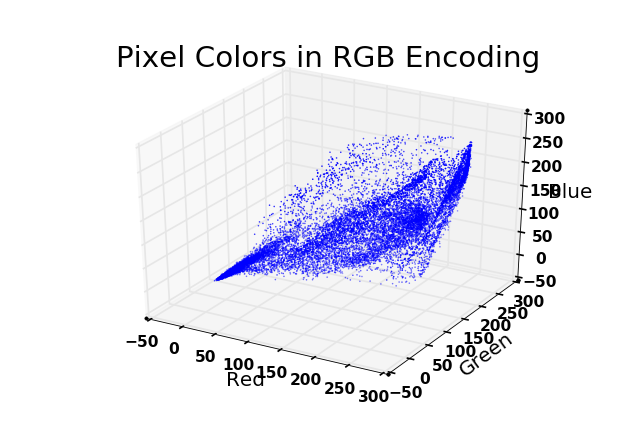

In [320]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
snp.labs("Red", "Green", "Pixel Colors in RGB Encoding")
ax.set_zlabel("Blue")
ax.scatter(parrot[:, :, 0], parrot[:, :, 1], zs=parrot[:, :, 2], s=2, lw=0)

First we need to reshape the image matrix into a 2-d array where each row is a 3-vector holding RGB for one pixel. Then we can feed this new matrix into K-Means. 

In [301]:
pixels = np.reshape(parrot, [128**2, 3])
color_clust = KMeans(n_clusters=16, n_init=20)
color_clust.fit(pixels)
color_clust.cluster_centers_

array([[ 149.94831461,  127.8258427 ,  114.34831461],
       [  21.74616588,   23.54491393,   20.94710485],
       [ 178.78476421,  160.58887545,  143.49214027],
       [ 221.73879259,  183.11715481,  116.46622833],
       [ 117.53549191,   99.18430884,   90.29016189],
       [ 118.13024602,   84.63965268,   45.99565847],
       [ 249.12785388,  241.26392694,  208.55068493],
       [ 193.61481481,  155.18240741,   87.48333333],
       [  42.86634557,   42.89704997,   40.79951836],
       [ 245.74574575,  219.18218218,  161.13313313],
       [ 234.15744681,  145.83191489,   64.4212766 ],
       [ 144.84462151,  183.51394422,  221.47410359],
       [  98.68518519,  116.66666667,  164.66666667],
       [ 166.25476992,  120.80022447,   54.24803591],
       [ 211.05306799,  190.33665008,  188.026534  ],
       [  73.92690355,   67.0822335 ,   66.84263959]])

The above points in RGB $R^3$ space are locations around which the colors in the parrot image tend to cluster (hopefully!). We can visualize the assignment of the original data points to clusters by color-coding them using the `labels_` attribute of the fitted `KMeans` object. 

<IPython.core.display.Javascript object>


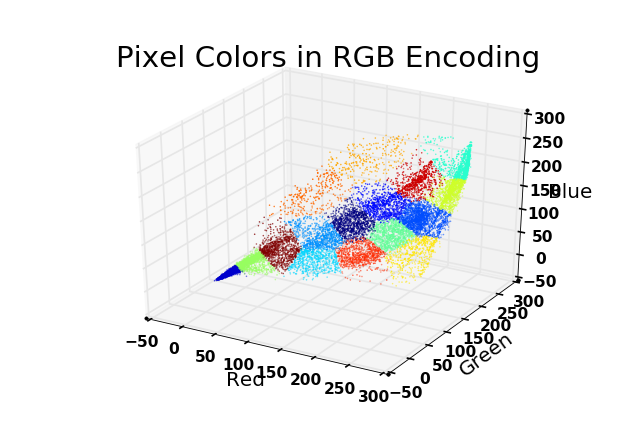

In [318]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
snp.labs("Red", "Green", "Pixel Colors in RGB Encoding")
ax.set_zlabel("Blue")
ax.scatter(parrot[:, :, 0], parrot[:, :, 1], zs=parrot[:, :, 2], c=color_clust.labels_, s=2, lw=0)

Now we need to do some legwork to actually see how the original image would look with the compressed color encoding. First we'll round all the numbers in the cluster centroids to integers. Then we'll use the `labels_` attribute of the K-Means object to identify which cluster each point belongs to and thus map it to the correct new color.

In [201]:
newcolors = np.round(color_clust.cluster_centers_)

In [217]:
def map_color(vec):
    cluster = color_clust.predict(vec.reshape(1, -1))
    return newcolors[cluster[0]]

compressed_parrot = np.apply_along_axis(map_color, 2, parrot)
compressed_parrot = compressed_parrot.astype(np.uint8)  # Cast to unsigned int so imshow knows what to do with it

<IPython.core.display.Javascript object>


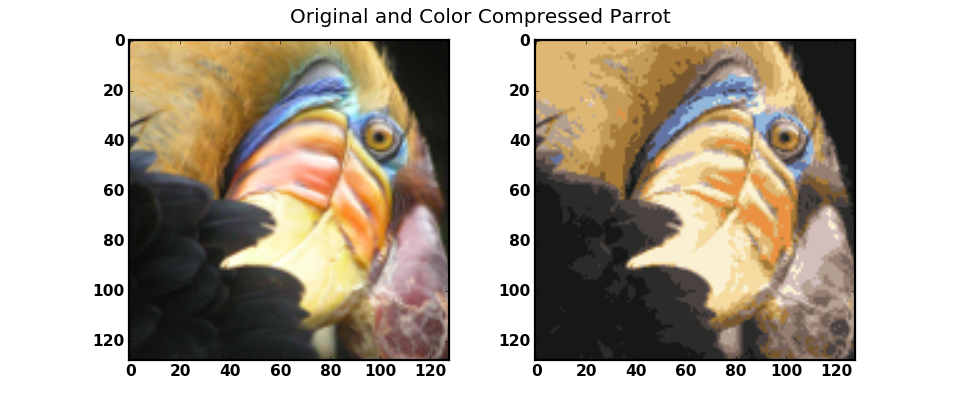

In [218]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Original and Color Compressed Parrot", fontsize=18)
axs[0].imshow(parrot)
axs[1].imshow(compressed_parrot)

For fun, let's look at the progression as we compress to fewer and fewer bits. The last image only needs $128^2$ bits to store (plus the dictionary mapping 0 and 1 to the two colors).

<IPython.core.display.Javascript object>


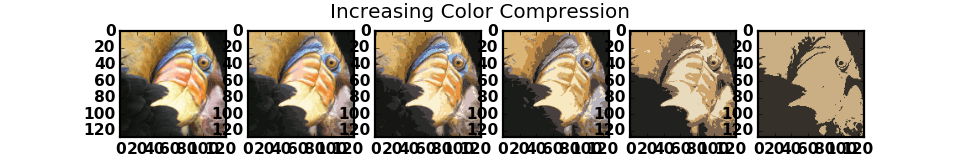

In [240]:
nclust = [64, 32, 16, 8, 4, 2]

fig, axs = plt.subplots(ncols=6, figsize=[12, 2])
fig.suptitle("Increasing Color Compression", fontsize=18)
plt.subplots_adjust(top=0.85)

for idx, n in enumerate(nclust):
    color_clust = KMeans(n_clusters=n, n_init=20)
    color_clust.fit(pixels)
    newcolors = np.round(color_clust.cluster_centers_)
    compressed_parrot = np.apply_along_axis(map_color, 2, parrot)
    compressed_parrot = compressed_parrot.astype(np.uint8) 
    axs[idx].imshow(compressed_parrot)

# Principle Component Analysis (PCA) Algorithm
Dimensionality reduction by PCA is an unsupervised algorithm that is often used for speeding up computations by data compression, and for visualizing data since we struggle to see anything above $R^3$.


 **PCA operates by trying to find a subspace (line for $R^2$, plane for $R^3$, etc.) that minimizes the Projection Error: the sum of squared distances from each point to it's projection into the chosen subspace (line, plane etc.).** If you can find a subspace where the projection error is small, that means the data do not have much "spread" along the direction perpendicular to it and thus it is a direction that can be safely discarded. 
\begin{align*}
\textrm{Average Projection Error:} \qquad \frac{1}{m}\sum_{i=1}^m ||x^{(i)} - x^{(i)}_{approx}||^2,
\end{align*}

where $x^{(i)}$ is an original point and $x^{(i)}$ is the location of it's projection into the subspace. 

In general to reduce $n$-dimensional data to $k$ dimensions you need to find $k$ linearly independent "directions" in the space $R^n$ which will define (span) the subspace you are projecting into. There is actually an analytical algorithm for this which is shown to minimize the projection error. 

### Choosing $k$
For data compression we want $k$ as small as possible without sacrificing significant *information* from the original data. When you reduce to a subspace you want the spread of the data along the direction orthogonal to that space to be very small - that's what justifies discarding the information contained by that orthogonal direction. This means after the reduction you won't have lost much of the total variance. Since we always center our data for PCA, $\mathrm{E}[x] = \vec{0}$ and so $1/m \sum^m||x^{(i)}||^2$ is a measure of random vector total variance. A common criteria for choosing $k$ is to make it as small as possible while losing no more than 1% of the original data set variance. With our definition of random vector variance, the lost variance is just the projection error so we can write the condition as:

\begin{align*}
\textrm{Choose $k$ as large as possible s.t.:} \qquad \frac{\textrm{variance lost}}{\textrm{original variance}} \equiv \frac{\frac{1}{m}\sum_{i=1}^m ||x^{(i)} - x^{(i)}_{approx}||^2}{\frac{1}{m}\sum_{i=1}^m ||x^{(i)}||^2,} \leq 0.01
\end{align*}

## PCA in sklearn
The sklearn tool for this is aptly named `PCA` and can be perused [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). The most crucial parameter for the `PCA` class is `n_components`: this specifies *either* the number of dimensions to compress to (if an integer) or the fraction of variance retained (if a float). **WARNING: It's critical to center your data before doing PCA.**

In [228]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=1)  # Reduce to k=1 dimensions
scaler = StandardScaler()

In [230]:
X = scaler.fit_transform(X2)
X_reduce = pca.fit_transform(X)

The `transform` method of the PCA class takes in your $n$-dimensional data points as a matrix, and returns a matrix holding $k$-dimensional data. After `fit`ting the `PCA` object has lots of useful attributes that are pretty self-explanatory:

In [239]:
print("The direction in feature space (%.2f, %.2f) explains %.2f of the original data variance."
      % (pca.components_[0][0], pca.components_[0][1], pca.explained_variance_ratio_))

The direction in feature space (-0.71, -0.71) explains 0.87 of the original data variance.


After compressing data you sometimes want to reverse the transformation and recover the original points in the full feature space - unfortunately since the mapping isn't one-to-one the best we can do is recover an approximation to our original points. This approximation just assigns zero value to the components in the discarded directions, and then executes a rotation to return to the original basis:

In [260]:
X_approx = pca.inverse_transform(X_reduce)

Let's plot the original data together with the "direction" or "subspace" that PCA has decided to project onto (a line in the original $R^2$ data space in this case). We'll also superimpose the approximaions to the original points that we get from `inverse_transform`.

<IPython.core.display.Javascript object>


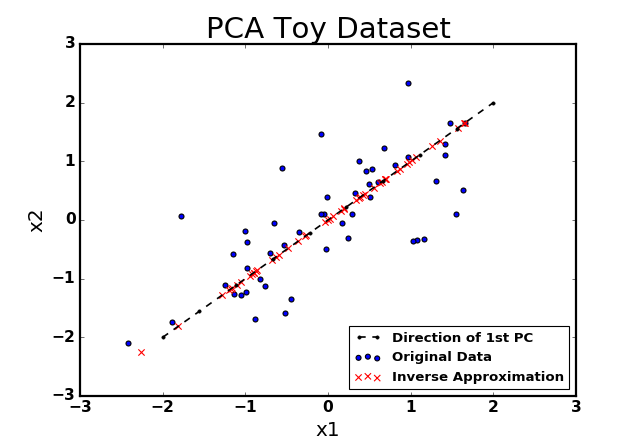

In [269]:
# Plot the original data points
fig, ax = plt.subplots()
snp.labs("x1", "x2", "PCA Toy Dataset")
ax.scatter(X[:, 0], X[:, 1], label="Original Data", c="b")

# Plot the component "direction" (intercept = 0 b/c of centering)
m = pca.components_[0][1]/pca.components_[0][0]  # slope of line
ax.plot(np.linspace(-2.5, 2, 10), m*np.linspace(-2, 2, 10), 
        color="black", linestyle="--", label="Direction of 1st PC")

# Plot the approximations obtained from inverse transform
ax.scatter(X_approx[:, 0], X_approx[:, 1], label="Inverse Approximation", c="r", marker="x", s=32)
ax.legend(loc="lower right")

## Data Compression with PCA
Here our task is to compress a data set that consists of grey-scale 32x32 pixel images, so that each data point (image) lives in $R^{1024}$. After we identify the principle components in this space, we can understand them better by recasting them to the 32x32 format and printing them just like a normal image. Full disclosure: it's gonna be creepy.

In [286]:
pca = PCA(n_components=32)  # Reduce to k=32 dimensions
faces = scaler.fit_transform(faces)  # remember to center first!
faces_reduce = pca.fit_transform(faces)

In [276]:
eigenfaces = pca.components_

<IPython.core.display.Javascript object>


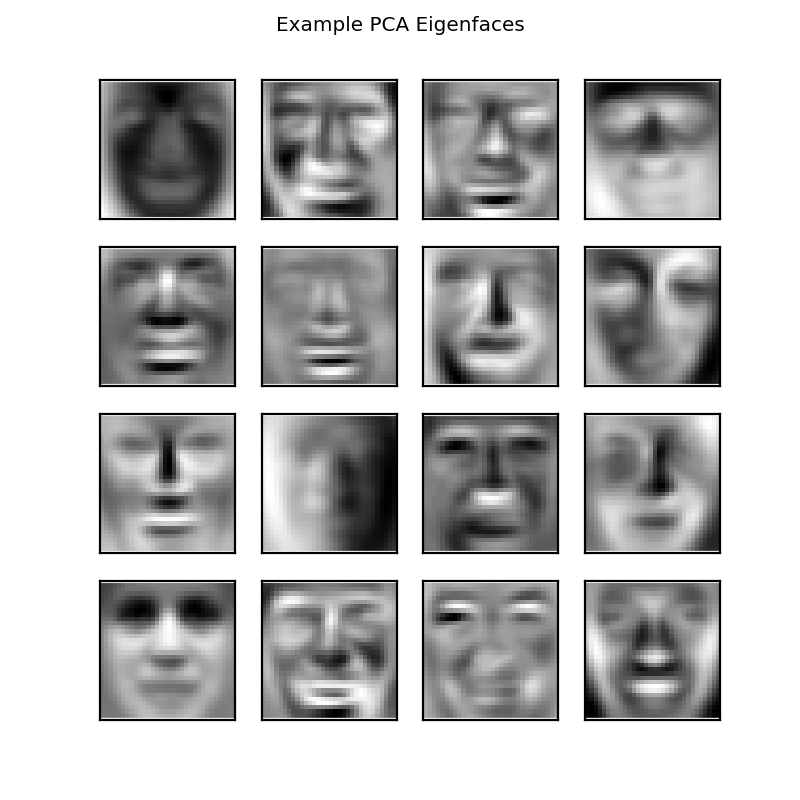

In [282]:
indxs = rnd.choice(np.arange(0, 31), 16, replace=False)  # take a random sample of size 16 from set of index values

 # Create a new figure with 16 axes objects inside it (subplots)
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10)) 
fig.suptitle("Example PCA Eigenfaces", fontsize=18)
axs = axs.flatten() 
graymap = plt.get_cmap("gray")

for i, indx in enumerate(indxs):
    im_mat = np.reshape(eigenfaces[indx, :], (32, 32), order="F")
    axs[i].imshow(im_mat, cmap=graymap, interpolation="None")
    axs[i].xaxis.set_visible(False)  # Hide the axes labels for clarity
    axs[i].yaxis.set_visible(False) 

AHHHHH, they're hideous! 

All faces share certain macroscopic features like eyes, a nose, a forehead, an oval shaped light area surrounded by dark area - this is *why* we are able to represent the images in a reduced dimension. The most efficient compression is obtained by identifying directions that capture those macroscopic features, so the principle components look like actual faces each emphasizing one or a few large-scale facial features. We call them eigenfaces.

Let's inverse-transform the reduced data to recover an approximation (in $R^{1024}$) to the original images, and we can plot a side-by-side comparison.

In [287]:
faces_approx = pca.inverse_transform(faces_reduce)

<IPython.core.display.Javascript object>


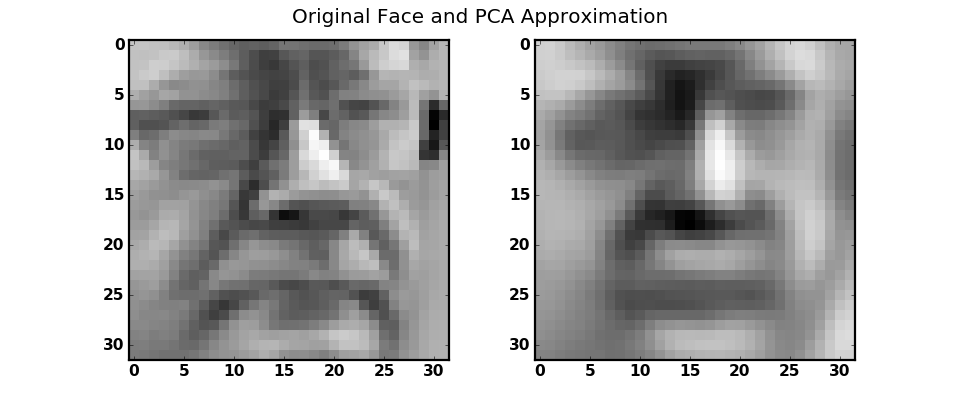

In [298]:
orig = faces[5, :].reshape(32, 32, order="F")
approx = faces_approx[5, :].reshape(32, 32, order="F")
fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Original Face and PCA Approximation", fontsize=18)
axs[0].imshow(orig, cmap=graymap, interpolation="None")
axs[1].imshow(approx, cmap=graymap, interpolation="None")

Not a *striking* likeness, but not bad for a 30-fold reduction in dimension! 

# Linear Discriminant Analysis (LDA)
LDA is an algorithm that can be used for the same purpose as PCA, but can take into account the labels on your data when deciding what "directions" to discard. Sklearn docs has a good [comparison of LDA vs PCA](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py) on the same data set. Note that LDA must reduce to *at most* the number of different classes, so it is only useful in certain contexts (read more [on the official docs](http://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)).

Here's a quick demo: In the parrot image each pixel is a point in $R^3$ (since it has an R, G and B intensity value) and I used K-Means to assign each of these points to one of 16 clusters. Now I want to a 2D visualization of the assignment of points into clusters, so I'll use LDA to reduce the $R^3$ representation of pixels into $R^2$ in a way that maximizes the separation between the 16 clusters.

In [303]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

In [304]:
pixels = np.reshape(parrot, [128**2, 3])
pixels_reduce = lda.fit_transform(pixels, color_clust.labels_)

<IPython.core.display.Javascript object>


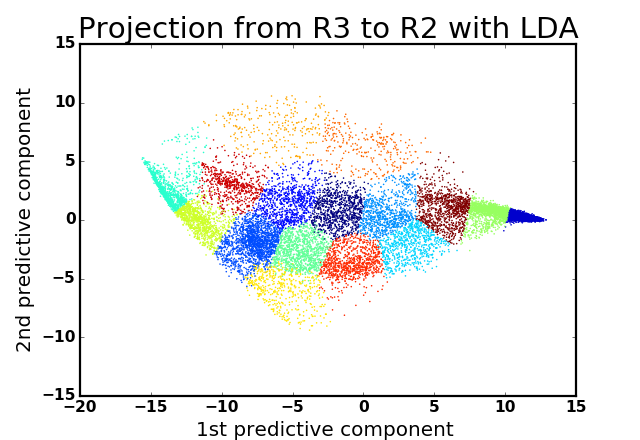

In [316]:
fig, ax = plt.subplots()
snp.labs("1st predictive component ", "2nd predictive component", "Projection from R3 to R2 with LDA")
ax.scatter(pixels_reduce[:, 0], pixels_reduce[:, 1], c=color_clust.labels_, s=2, lw=0)

# In Summary
K-Means is an unsupervised algorithm that groups data into K coherent clusters, each cluster has a centroid located at the average position of it's constituent points. The objective function to minimize is the sum of squared distances between points and their assigned cluster centroids, but the typical algorithm has local optima so it is best to randomly initialize and run the algorithm 50 - 1000 times. You can use sklearn's `KMeans` class for this, specifying `n_clusters` and other parameters of the algorithm - you first `fit` the class and then you can use it to `predict` cluster assignment for new data.

PCA is the most common algorithm for reducing dimensionality of data for compression (speed) or visualization purposes. We find a subspace of our original feature space (line for R2, plane for R3, etc.) that minimizes the Projection Error: the sum of squared distances from each point to it's projection into the subspace. If the projection error is small the data do not have much "spread" along the direction perpendicular to the subspace and thus that direction can be discarded without losing much predictive information. When compressing from n to k dimensions an analyical algorithm exists for finding the subspace that minimizes this error, but note it is **CRTIICAL** to center your features first. When compressing for speed purposes, we choose k to be as small as possible while still retaining the majority of the variance of the original data. You can use sklearn's `PCA` class for this, specifying `n_components` as an integer for $k$ dimensions or as a float for percentage of variance retained.

Linear Discriminant Analysis (LDA) can be used for the same purpose as PCA, but can take into account the labels on your data when deciding what "directions" to discard as least predictive. You can use sklearn's `LinearDiscriminantAnalysis` and specify `n_components`.